Simulate age and income

In [133]:
import numpy as np

N = 5000

age = np.random.randint(16, 75, N)

Text(0, 0.5, 'Number of customers')

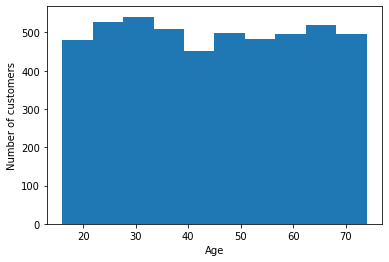

In [134]:
import matplotlib.pyplot as plt

plt.hist(age)
plt.xlabel("Age")
plt.ylabel("Number of customers")

Text(0, 0.5, 'Frequency')

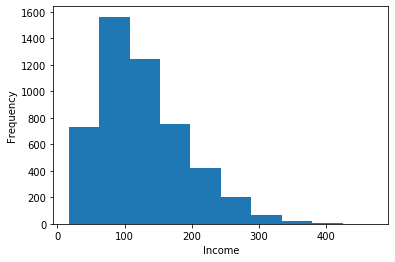

In [135]:
income = age + np.abs(np.random.normal(20, 100, N))

plt.hist(income)
plt.xlabel("Income")
plt.ylabel("Frequency")

In [136]:
def calculate_class(age, income):
    if age < 30:
        if income >= 300:
            return 2
        elif income >= 200:
            return 1
        else:
            return 0
    elif age < 50:
        if income >= 250:
            return 2
        elif income >= 150:
            return 1
        else:
            return 0
    elif age < 60:
        if income >= 150:
            return 2
        elif income >= 75:
            return 1
        else:
            return 0
    else:
        if income >= 200:
            return 2
        elif income >= 150:
            return 1
        else:
            return 0



In [137]:
def calculate_response(age):
    if age < 50:
        return 1 if np.random.random() < 0.5 else 0
    else:
        return 1 if np.random.random() < 0.3 else 0

In [138]:
_class = list(map(lambda x, y: calculate_class(x, y), age, income))

In [139]:
response = list(map(lambda x: calculate_response(x), age))

Text(0, 0.5, 'Frequency')

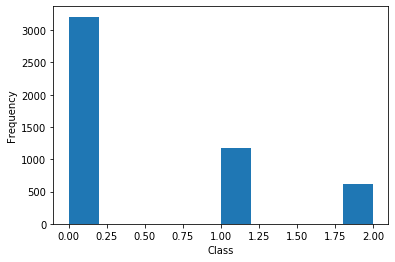

In [140]:
import matplotlib.pyplot as plt

plt.hist(_class)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [141]:
def segmentation(_class, response):
    if _class == 2:
        if response == 1:
            return 2
        else:
            return 1
    elif _class == 1:
        if response == 1:
            return 2
        else:
            return 1
    elif _class == 0:
        if response == 1:
            return 1
        else:
            return 0

In [142]:
segment = list(map(lambda x, y: segmentation(x, y), _class, response))

In [143]:
import pandas as pd

data = {'age': age, 'income': income, 'class': _class, 'response': response, 'segment': segment}
df = pd.DataFrame(data)
df

,age,income,class,response,segment
0,62,107.126731,0,0,0
1,73,186.207815,1,1,2
2,17,212.616829,1,0,1
3,70,189.768610,1,1,2
4,31,234.887581,1,1,2
...,...,...,...,...,...
4995,22,77.625414,0,1,1
4996,51,187.858664,2,1,2
4997,39,68.761326,0,1,1
4998,36,176.050972,1,1,2


In [144]:
df.describe()

,age,income,class,response,segment
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,44.834400,126.297874,0.481600,0.406800,0.765200
std,16.978004,64.502354,0.704387,0.491286,0.657385
min,16.000000,16.685435,0.000000,0.000000,0.000000
25%,30.000000,78.129405,0.000000,0.000000,0.000000
50%,44.000000,113.879357,0.000000,0.000000,1.000000
75%,60.000000,162.521950,1.000000,1.000000,1.000000
max,74.000000,470.425142,2.000000,1.000000,2.000000


Text(0.5, 1.0, 'Segment by age and income')

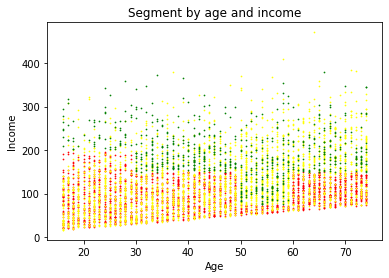

In [145]:
colours = {0: 'red', 1: 'yellow', 2: 'green'}
for segment in [0, 1, 2]:
    df_s = df[df.segment == segment]
    plt.scatter(df_s.age, df_s.income, c=colours[segment], s=0.5)
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Segment by age and income")

In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from nyoka import skl_to_pmml

In [147]:
outputs = df['segment']
inputs = df[['age', 'income', 'response']]

In [148]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.4, random_state=23)

In [149]:
def build_RF_pipeline(inputs, outputs, rf=None):
    if not rf:
        rf = RandomForestClassifier()
    pipeline = Pipeline([
        ("classifier", rf)
    ])
    pipeline.fit(inputs, outputs)
    return pipeline

In [157]:
def RF_estimation(inputs, outputs,
                  estimator_steps=10,
                  depth_steps=10,
                  min_samples_split=None,
                  min_samples_leaf=None):
    # hyper-parameter estimation
    n_estimators = [int(x) for x in np.linspace(start=50, stop=100, num=estimator_steps)]
    max_depth = [int(x) for x in np.linspace(3, 10, num=depth_steps)]
    max_depth.append(None)
    if not min_samples_split:
        min_samples_split = [1, 2, 4]
    if not min_samples_leaf:
        min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=random_grid,
                                   n_iter=100, scoring='neg_mean_absolute_error',
                                   cv=3, verbose=1, random_state=42, n_jobs=-1)
    rf_random.fit(inputs, outputs)
    best_random = rf_random.best_estimator_
    print(best_random)
    return best_random

In [158]:
rf = RF_estimation(X_train, y_train, estimator_steps=5, depth_steps=5)
random_forest_pipeline = build_RF_pipeline(X_train, y_train, rf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    9.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.0s finished
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=62,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [159]:
rf_predictions = random_forest_pipeline.predict(X_test)
print(f"MSE: {random_forest_pipeline.score(X_test, y_test)*100}%")

MSE: 99.85000000000001%


In [160]:
skl_to_pmml(random_forest_pipeline, ['age', 'income', 'response'], 'segment',"models/rf_segmentation_small.pmml")

In [161]:
# save the sample dataset
df.to_csv("data/dataset.csv")